In [3]:
from PIL import Image, ImageDraw, ImageEnhance, ImageFont, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import imp 
from pylab import *
from scipy.ndimage import filters
from scipy.ndimage import measurements, morphology
import scipy.ndimage as ndimage

In [1662]:
def show_3_image(image):
    """Выводим изображние + 3 его составляющие"""
    fig=plt.figure(figsize=(15, 15))
    fig.add_subplot(1, 4, 1)
    plt.imshow(image)
    fig.add_subplot(1, 4, 2)
    plt.imshow(image[:,:,0])
    fig.add_subplot(1, 4, 3)
    plt.imshow(image[:,:,1])
    fig.add_subplot(1, 4, 4)
    plt.imshow(image[:,:,2])
    plt.show()

In [1663]:
def binary_image_f(image, limit, color):
    """Бинаризация изображения
    limit - пороговое значение пикселя
    color - цвет для порогового значения 'r', 'g', 'b'
    """
    result_image = Image.fromarray(image)
    width = image.shape[1]
    height = image.shape[0]
    pix = Image.fromarray(image).load() # значения пикселей
    draw = ImageDraw.Draw(result_image) #Создаем инструмент для рисования
    for i in range(width):
        for j in range(height):
            r = pix[i, j][0]
            g = pix[i, j][1]
            b = pix[i, j][2]
            if (color=='r' and r > limit):
                r, g, b = 255, 255, 255
            elif (color=='g' and g > limit):
                r, g, b = 255, 255, 255
            elif(color=='b' and b > limit):
                r, g, b = 255, 255, 255
            else:
                r, g, b = 0, 0, 0                
            draw.point((i, j), (r, g, b))
    return result_image

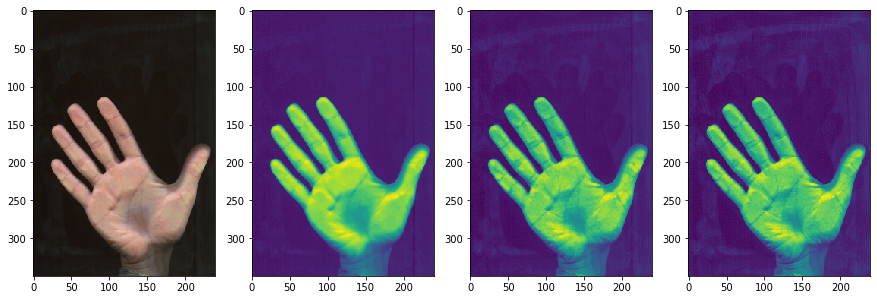

In [2829]:
image_origin = Image.open("035.tif").resize((250, 350))
w, h = image_origin.size
image_origin = image_origin.crop((0, 0, w-10, h))
image = np.array(image_origin.copy())

show_3_image(image)

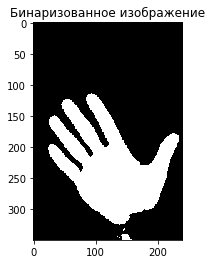

In [2830]:
plt.title('Бинаризованное изображение')
binary_image = binary_image_f(image, 100, 'r')
plt.imshow(binary_image)

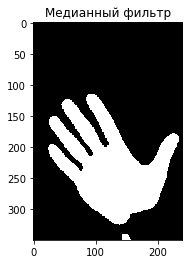

In [2831]:
plt.title('Медианный фильтр')
im1 = binary_image
im1 = im1.filter(ImageFilter.MedianFilter(5))
plt.imshow(im1)

In [2832]:
# расчет дистанций от границ
from scipy import ndimage
distances, indices = ndimage.distance_transform_edt(np.array(im1)[:,:,0], return_distances=True, return_indices=True)

In [2833]:
# функция возвращает N максимальных элементов в списке
def Nmaxelements(list1, N): 
    final_list = [] 
    for i in range(0, N):  
        max1 = 0
        for j in range(len(list1)):      
            if list1[j] > max1: 
                max1 = list1[j]; 
        list1.remove(max1); 
        final_list.append(max1) 
    return final_list

# функция возвращает N минимальных элементов в списке
def Nminelements(list1, N): 
    final_list = [] 
    for i in range(0, N):  
        max1 = max(list1)
        for j in range(len(list1)):      
            if list1[j] < max1 and list1[j] != 0 and not list1[j] in final_list: 
                max1 = list1[j]; 
        list1.remove(max1); 
        final_list.append(max1) 
    return final_list

In [2834]:
# функция возвращает boolean наличия вокруг координаты красных точек по рамке
# def have_points_around_outer(x , y, image, size=20):
#     im = np.array(image.copy())
#     frame_size = size # размер рамки
#     for ii in range(x-frame_size, x+frame_size):
#         for jj in range(y-frame_size, y+frame_size):
#             try:
#                 if (im[jj, ii][0] == 255 and im[jj, ii][1] == 0 and im[jj, ii][2] == 0):
#                     return True
#             except IndexError:
#                 pass
#     return False


# функция возвращает boolean наличия вокруг координаты зеленых точек по рамке
# def have_points_around_inner(x , y, image, size=18):
#     im = np.array(image.copy())
#     frame_size = size # размер рамки
#     for ii in range(x-frame_size, x+frame_size):
#         for jj in range(y-frame_size, y+frame_size):
#             try:
#                 if (im[jj, ii][0] == 0 and im[jj, ii][1] == 255 and im[jj, ii][2] == 0):
#                     return True
#             except IndexError:
#                 pass
#     return False

In [2835]:
import PIL.ImageDraw as ImageDraw,PIL.Image as Image, PIL.ImageShow as ImageShow 
# max_elemets - содержит одно значение =  максимальное расстояние (соответствует цинтру ладони)
max_elemets = Nmaxelements(distances[:,:].reshape(-1).tolist(), 1)
# min_elemets - содержит одно значение = минимальное расстояние до границы (сама граница)
min_elemets = Nminelements(distances[:,:].reshape(-1).tolist(), 1)

red_points = []  #координаты красных точек кроме центра (концы пальцев)
green_points = []  #координаты красных точек кроме центра  (впадины руки)
center = [] # центр ладони

im = im1.copy()
draw = ImageDraw.Draw(im)

for i in range(len(max_elemets)):
    indexes_max = np.where(distances == max_elemets[i])
    draw.point((indexes_max[1][0],indexes_max[0][0]),fill=(255, 0, 0))
    center = (indexes_max[1][0],indexes_max[0][0])
#     закращиваем все точки равноудаленные от границы, а не одну центральную
#     for j in range(indexes_max[0].shape[0]):
#         draw.point((indexes_max[1][j],indexes_max[0][j]),fill=(255, 0, 0))
    
evclids = []  # евклидово расстояние от всех точек границы до центра
# считаем евклидово расстояние от всех границ
for i in range(len(min_elemets)):
    indexes_min = np.where(distances[:, :] == min_elemets[i])
    for j in range(indexes_min[0].shape[0]):
        point = (indexes_min[1][j],indexes_min[0][j])
        center = (indexes_max[1][0], indexes_max[0][0])
        evclids.append(distance.euclidean(point, center))
        
# отбираем точки с максимальным евклидовым расстоянием 
max_evclids = Nmaxelements(evclids, 400)
max_evclids.sort()
# закрашиваем их красным цветом
for i in range(len(min_elemets)):
    indexes_min = np.where(distances[:, :] == min_elemets[i])
    for j in range(indexes_min[0].shape[0]):
        point = (indexes_min[1][j],indexes_min[0][j])
        center = (indexes_max[1][0], indexes_max[0][0])
        if distance.euclidean(point, center) in max_evclids:
            # если рядом нет  уже красных точек в определенном радиусе
#             if not (have_points_around_outer(indexes_min[1][j], indexes_min[0][j], im)):
            draw.point((indexes_min[1][j],indexes_min[0][j]),fill=(255, 0, 0))
            red_points.append((indexes_min[1][j],indexes_min[0][j]))
            
# отбираем точки с минимальным евклидовым расстоянием 
min_evclids = Nminelements(evclids, 300)
min_evclids.sort(reverse=True)
# закрашиваем их в зеленый цвет
for i in range(len(min_elemets)):
    indexes_min = np.where(distances[:, :] == min_elemets[i])
    for j in range(indexes_min[0].shape[0]):
        point = (indexes_min[1][j],indexes_min[0][j])
        center = (indexes_max[1][0], indexes_max[0][0])
        if distance.euclidean(point, center) in min_evclids:
#             if not (have_points_around_inner(indexes_min[1][j], indexes_min[0][j], im)):
            draw.point((indexes_min[1][j],indexes_min[0][j]),fill=(0, 255, 0))
            green_points.append((indexes_min[1][j],indexes_min[0][j]))
            
            
im.show()

In [2836]:
all_red_points = red_points.copy()
all_green_points = green_points.copy()

# Функция возвразает координаты и расстояние самой удаленной точки от центра в "группе" красных точек
def get_max_red_point(point):
    all_red_points.remove(point)
    red_point_deleted.append(point)
    d = distance.euclidean(point, center)
    p = point
    d1, d2, d3, d4, d5, d6, d7, d8 = 0, 0, 0, 0, 0, 0, 0, 0  # точки вокруг
    if ((p[0]-1, p[1]-1) in all_red_points):
        p1 = (p[0]-1, p[1]-1)
        p1, d1 = get_max_point(p1)
    if ((p[0]-1, p[1]+1) in all_red_points): 
        p2 = (p[0]-1, p[1]+1)
        p2, d2 = get_max_point(p2)
    if ((p[0]+1, p[1]-1) in all_red_points): 
        p3 = (p[0]+1, p[1]-1)
        p3, d3 = get_max_point(p3)
    if ((p[0]+1, p[1]+1) in all_red_points): 
        p4 = (p[0]+1, p[1]+1)
        p4, d4 = get_max_point(p4)
    if ((p[0], p[1]-1) in all_red_points): 
        p5 = (p[0], p[1]-1)
        p5, d5 = get_max_point(p5)
    if ((p[0], p[1]+1) in all_red_points): 
        p6 = (p[0], p[1]+1)
        p6, d6 = get_max_point(p6)
    if ((p[0]-1, p[1]) in all_red_points): 
        p7 = (p[0]-1, p[1])
        p7, d7 = get_max_point(p7)
    if ((p[0]+1, p[1]) in all_red_points): 
        p8 = (p[0]+1, p[1])
        p8, d8 = get_max_point(p8)
    max_d = max(d, d1, d2, d3, d4, d5, d6, d7, d8)
    if (max_d == d):
        try:
            return p, d
        except:
            pass
    if (max_d == d1):
        try:
            return p1, d1
        except:
            pass
    if (max_d == d2):
        try:
            return p2, d2
        except:
            pass
    if (max_d == d3):
        try:
            return p3, d3
        except:
            pass
    if (max_d == d4):
        try:
            return p4, d4
        except:
            pass
    if (max_d == d5):
        try:
            return p5, d5
        except:
            pass
    if (max_d == d6):
        try:
            return p6, d6
        except:
            pass
    if (max_d == d7):
        try:
            return p7, d7
        except:
            pass
    if (max_d == d8):
        try:
            return p8, d8
        except:
            pass
    
# Функция возвразает координаты и расстояние самой близкой точки от центра в "группе" зеленых точек
def get_max_green_point(point):
    all_green_points.remove(point)
    d = distance.euclidean(point, center)
    p = point
    d1, d2, d3, d4, d5, d6, d7, d8 = 999999, 999999, 999999, 999999, 999999, 999999, 999999, 999999  # точки вокруг
    if ((p[0]-1, p[1]-1) in all_green_points):
        p1 = (p[0]-1, p[1]-1)
        p1, d1 = get_max_green_point(p1)
    if ((p[0]-1, p[1]+1) in all_green_points): 
        p2 = (p[0]-1, p[1]+1)
        p2, d2 = get_max_green_point(p2)
    if ((p[0]+1, p[1]-1) in all_green_points): 
        p3 = (p[0]+1, p[1]-1)
        p3, d3 = get_max_green_point(p3)
    if ((p[0]+1, p[1]+1) in all_green_points): 
        p4 = (p[0]+1, p[1]+1)
        p4, d4 = get_max_green_point(p4)
    if ((p[0], p[1]-1) in all_green_points): 
        p5 = (p[0], p[1]-1)
        p5, d5 = get_max_green_point(p5)
    if ((p[0], p[1]+1) in all_green_points): 
        p6 = (p[0], p[1]+1)
        p6, d6 = get_max_green_point(p6)
    if ((p[0]-1, p[1]) in all_green_points): 
        p7 = (p[0]-1, p[1])
        p7, d7 = get_max_green_point(p7)
    if ((p[0]+1, p[1]) in all_green_points): 
        p8 = (p[0]+1, p[1])
        p8, d8 = get_max_green_point(p8)
    max_d = min(d, d1, d2, d3, d4, d5, d6, d7, d8)
    if (max_d == d):
        try:
            return p, d
        except:
            pass
    if (max_d == d1):
        try:
            return p1, d1
        except:
            pass
    if (max_d == d2):
        try:
            return p2, d2
        except:
            pass
    if (max_d == d3):
        try:
            return p3, d3
        except:
            pass
    if (max_d == d4):
        try:
            return p4, d4
        except:
            pass
    if (max_d == d5):
        try:
            return p5, d5
        except:
            pass
    if (max_d == d6):
        try:
            return p6, d6
        except:
            pass
    if (max_d == d7):
        try:
            return p7, d7
        except:
            pass
    if (max_d == d8):
        try:
            return p8, d8
        except:
            pass


# находим крайние красные точки в группах
res_red = []
for pp in all_red_points:
    a, b = get_max_red_point(pp)
    res_red.append(a)

# находим крайние зеленые точки в группах
res_green = []
for pp in all_green_points:
    a, b = get_max_green_point(pp)
    res_green.append(a)

#  отобразим их
filtered_image = im.copy()
draw2 = ImageDraw.Draw(filtered_image)
for point in res_red:
    draw2.point((point[0], point[1]),fill=(0, 255, 0))
for point in res_green:
    draw2.point((point[0], point[1]),fill=(255, 0, 0))
filtered_image.show()  

In [2837]:
print(res_red)
print(res_green)

[(90, 115), (50, 125), (29, 152), (232, 183), (25, 199)]
[(117, 200), (164, 220), (93, 215), (80, 235), (103, 303), (145, 332)]


In [2838]:
red_points = res_red 
filtered_image = im.copy()
test_image = np.array(im.copy())
draw2 = ImageDraw.Draw(filtered_image)
red_points_2 = red_points.copy()

# for point in red_points:
#     draw2.point((point[0], point[1]),fill=(0, 0, 255))
# filtered_image.show()

In [2839]:
# Убираем лишние красные точки путем построения пути (смотрим цвет пути)
# print(red_points_2)
# for point in red_points:
#     for other_point in red_points:
#         if (point != other_point):
#             # Сначала движемся по oY а потом по oX (проверяем ли есть 'чистый путь')
#             delete = False
#             x1 = point[0]
#             y1 = point[1]
#             x2 = other_point[0]
#             y2 = other_point[1]
#             while ((not delete) and abs(y1 - y2) > 0 and y1 < test_image.shape[0]):
#     #             draw.point((x1, y1 + np.sign(y1 - y2)),fill=(255, 0, 0))
#                 y1 = y1 - np.sign(y1 - y2)
#                 if (test_image[y1 + np.sign(y1 - y2), x1][0] == 0 
#                     and test_image[y1 + np.sign(y1 - y2), x1][1] == 0
#                     and test_image[y1 + np.sign(y1 - y2), x1][2] == 0):
#                     delete = True
#             while ((not delete) and abs(x1 - x2) > 0 and x1 < test_image.shape[1]):
#     #             draw.point((x1 + np.sign(x1 - x2), y1),fill=(255, 0, 0))
#                 x1 = x1 - np.sign(x1 - x2)
#                 if (test_image[y1, x1 + np.sign(x1 - x2)][0] == 0 
#                     and test_image[y1, x1 + np.sign(x1 - x2)][1] == 0
#                     and test_image[y1, x1 + np.sign(x1 - x2)][2] == 0):
#                     delete = True
#             if (not delete):
# #                 draw2.point((x2, y2),fill=(255, 255, 255))
#                 red_points.remove(other_point)
#             # Движемся по oY а потом по oX (проверяем ли есть 'чистый путь') - для повернутых изображений
#             while ((not delete) and abs(x1 - x2) > 0 and x1 < test_image.shape[1]):
#                 x1 = x1 - np.sign(x1 - x2)
#                 if (test_image[y1, x1 + np.sign(x1 - x2)][0] == 0 
#                     and test_image[y1, x1 + np.sign(x1 - x2)][1] == 0
#                     and test_image[y1, x1 + np.sign(x1 - x2)][2] == 0):
#                     delete = True
#             while ((not delete) and abs(y1 - y2) > 0 and y1 < test_image.shape[0]):
#                 y1 = y1 - np.sign(y1 - y2)
#                 if (test_image[y1 + np.sign(y1 - y2), x1][0] == 0 
#                     and test_image[y1 + np.sign(y1 - y2), x1][1] == 0
#                     and test_image[y1 + np.sign(y1 - y2), x1][2] == 0):
#                     delete = True
#             if (not delete):
# #                 draw2.point((x2, y2),fill=(255, 255, 255))
#                 try: 
#                     red_points.remove(other_point)
#                 except:
#                     pass
# for point in red_points:
#     draw2.line((point[0], point[1], center[0], center[1]), fill=(255,0,0)) 
# for point in red_points:
#     draw2.point((point[0], point[1]),fill=(0, 255, 0))
# filtered_image.show()
# print(red_points)

In [2840]:
res_red = red_points.copy()
res_red

[(90, 115), (50, 125), (29, 152), (232, 183), (25, 199)]

In [2841]:
# def getMinElements(list1, center, N):
#     inner_list = list1.copy()
#     final_list = [] 
#     for i in range(0, N):
#         max_d = 99999999999999
#         pp = ()
#         for p in inner_list:
#             if distance.euclidean(p, center) <= max_d:
#                 max_d = distance.euclidean(p, center)
#                 pp = p
#         if pp != ():
#             inner_list.remove(pp)
#             final_list.append(pp)
#     return final_list
                

# # Среди всех зеленых точек оставляем те, которые ближе всего к красным (по 3 шт)
# k = 3;
# success_green_points = set()
# for point in red_points:
#     for el in getMinElements(green_points, point, 15):
#         success_green_points.add(el)
# success_green_points

In [2842]:
# Имеем точки
# res_red - координаты концов пальцев
# res_green - координаты точек между пальцами
# center - центр ладони
res_red, res_green, center

([(90, 115), (50, 125), (29, 152), (232, 183), (25, 199)],
 [(117, 200), (164, 220), (93, 215), (80, 235), (103, 303), (145, 332)],
 (127, 257))

In [2843]:
filtered_image = im.copy()
draw2 = ImageDraw.Draw(filtered_image)

for point in res_red:
    draw2.line((point[0], point[1], center[0], center[1]), fill=(255,0,0)) 
for point in res_green:
    draw2.point((point[0], point[1]),fill=(0, 255, 0))
filtered_image.show()
print(red_points)

[(90, 115), (50, 125), (29, 152), (232, 183), (25, 199)]


In [2844]:
# Отметим новые зеленые точки
# f = image_origin
# draw_result = ImageDraw.Draw(f)
# for point in res_red:
#     draw_result.line((point[0], point[1], center[0], center[1]), fill=(255,0,0))
# for point in res_green:
#     draw_result.line((point[0], point[1], center[0], center[1]), fill=(0,255,0)) 
    
# f.show()

In [2845]:
# Функция возвращающая ближайшую из list точек к данной
def get_near_point(point, lists):
    lists.remove(point)
    min_d = 9999999
    result = point
    for p in lists:
        if distance.euclidean(point, p) < min_d:
            min_d = distance.euclidean(point, p)
            result = p
    return result

In [2846]:
res_red

[(90, 115), (50, 125), (29, 152), (232, 183), (25, 199)]

In [2847]:
distances = set()
finish_red_points = set()
red_red_red = res_red.copy()
red_red_red.sort()

for a in res_red:
    b = get_near_point(a, red_red_red)
    c = get_near_point(b, red_red_red)
    d = get_near_point(c, red_red_red)
    e = get_near_point(d, red_red_red)
#     print(a, b, c, d, e)
    summ_dist = distance.euclidean(a, b) + distance.euclidean(b, c) + distance.euclidean(c, d) + distance.euclidean(d, e)
    distances.add(summ_dist)
    red_red_red = res_red.copy()
    red_red_red.sort()

distances = list(distances)
distances.sort()
red_red_red = res_red.copy()
red_red_red.sort()
# берем 4 минимальных расстояний
N = 1
print(distances)
while (len(finish_red_points) < 4):
    for a in red_red_red:
        b = get_near_point(a, red_red_red)
        c = get_near_point(b, red_red_red)
        d = get_near_point(c, red_red_red)
        e = get_near_point(d, red_red_red)
#         print(a, b, c, d, e)
        summ_dist = distance.euclidean(a, b) + distance.euclidean(b, c) + distance.euclidean(c, d) + distance.euclidean(d, e)
        if (summ_dist in distances[:N]):
            finish_red_points.add(a)
            finish_red_points.add(b)
            finish_red_points.add(c)
            finish_red_points.add(d)
            finish_red_points.add(e)
        red_red_red = res_red.copy()
        red_red_red.sort()
    N = N + 1

# print(distances)
print(distances[:4])
print(finish_red_points)

f = image_origin.copy()
draw_result = ImageDraw.Draw(f)
for point in finish_red_points:
    draw_result.line((point[0], point[1], center[0], center[1]), fill=(255,0,0))
for point in res_green:
    draw_result.line((point[0], point[1], center[0], center[1]), fill=(0,255,0)) 
    
f.show()

[280.048277501579, 330.22366131674426, 345.0292732922393, 389.2658077032982]
[280.048277501579, 330.22366131674426, 345.0292732922393, 389.2658077032982]
{(232, 183), (25, 199), (50, 125), (29, 152), (90, 115)}


In [2848]:
print(finish_red_points)
print(res_green)

{(232, 183), (25, 199), (50, 125), (29, 152), (90, 115)}
[(117, 200), (164, 220), (93, 215), (80, 235), (103, 303), (145, 332)]


In [2849]:
# Функция возвращающая ближайшие COUNT точек из list точек к данной
def get_near_point(point, lists, count):
    distances = list()
    result = list()
    for p in lists:
        distances.append(distance.euclidean(point, p))
    distances.sort()
    for p in lists:
        if distance.euclidean(point, p) in distances[:count]:
            result.append(p)
    return result

In [2850]:
optim_green_points = set()
for p in finish_red_points:
    for optim_points in get_near_point(p, res_green, 2):
        optim_green_points.add(optim_points)
print(optim_green_points)

f = image_origin.copy()
draw_result = ImageDraw.Draw(f)
for point in finish_red_points:
    draw_result.line((point[0], point[1], center[0], center[1]), fill=(255,0,0))
for point in optim_green_points:
    draw_result.line((point[0], point[1], center[0], center[1]), fill=(0,255,0)) 
    
f.show()

{(80, 235), (164, 220), (93, 215), (117, 200)}
